In [33]:
import pandas as pd 
import numpy as np 

## ARIMA with Merged dataset
- Simple EDA
- Stationary
    - ACF, PACF
    - ADF test
- ARIMA/SARIMA with certain parameters
- Auto arima

In [34]:
train = pd.read_csv("../data/features/train.csv", index_col=0)
test = pd.read_csv("../data/features/test.csv", index_col=0)

In [35]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2018352 entries, 0 to 2018351
Data columns (total 57 columns):
 #   Column                                    Dtype  
---  ------                                    -----  
 0   county                                    int64  
 1   is_business                               int64  
 2   product_type                              int64  
 3   target                                    float64
 4   is_consumption                            int64  
 5   datetime                                  object 
 6   data_block_id                             int64  
 7   row_id                                    int64  
 8   prediction_unit_id                        int64  
 9   date                                      object 
 10  year                                      int64  
 11  quarter                                   int64  
 12  month                                     int64  
 13  week                                      int64  
 14  hour   

In [36]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12480 entries, 0 to 12479
Data columns (total 57 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   county                                    12480 non-null  int64  
 1   is_business                               12480 non-null  int64  
 2   product_type                              12480 non-null  int64  
 3   is_consumption                            12480 non-null  int64  
 4   datetime                                  12480 non-null  object 
 5   data_block_id                             12480 non-null  int64  
 6   row_id                                    12480 non-null  int64  
 7   prediction_unit_id                        12480 non-null  int64  
 8   currently_scored                          12480 non-null  bool   
 9   date                                      12480 non-null  object 
 10  year                                   

### 연속적인 시계열을 이루고 있는지?
- 시계열 데이터는 빈 곳 없이 연속적으로, 주기에 맞춰 존재해야 함.
- train set확인 결과, 일부 `prediction_unit_id`에서 연속적이지 않은 시계열을 가진 것을 확인함. 
- 일단, `prediction_unit_it` == 0 인 세그먼트만 가지고 ARIMA 분석을 진행

In [37]:
train.groupby(["prediction_unit_id", "is_consumption"]).count()

county  is_business  product_type  target  \
prediction_unit_id is_consumption                                              
0                  0                15312        15312         15312   15308   
                   1                15312        15312         15312   15308   
1                  0                15312        15312         15312   15308   
                   1                15312        15312         15312   15308   
2                  0                15312        15312         15312   15308   
...                                   ...          ...           ...     ...   
66                 1                12384        12384         12384   12381   
67                 0                11640        11640         11640   11637   
                   1                11640        11640         11640   11637   
68                 0                 1656         1656          1656    1656   
                   1                 1656         1656          1656    1656   

                                   datetime  data_block_id  row_id   date  \
prediction_unit_id is_consumption                                           
0                  0                  15312          15312   15312  15312   
                   1                  15312          15312   15312  15312   
1                  0                  15312          15312   15312  15312   
                   1                  15312          15312   15312  15312   
2                  0                  15312          15312   15312  15312   
...                                     ...            ...     ...    ...   
66                 1                  12384          12384   12384  12384   
67                 0                  11640          11640   11640  11640   
                   1                  11640          11640   11640  11640   
68                 0                   1656           1656    1656   1656   
                   1                   1656           1656    1656   1656   

                                    year  quarter  ...  snowfall_f_mean  \
prediction_unit_id is_consumption                  ...                    
0                  0               15312    15312  ...            15286   
                   1               15312    15312  ...            15286   
1                  0               15312    15312  ...            15286   
                   1               15312    15312  ...            15286   
2                  0               15312    15312  ...            15286   
...                                  ...      ...  ...              ...   
66                 1               12384    12384  ...            12382   
67                 0               11640    11640  ...            11638   
                   1               11640    11640  ...            11638   
68                 0                1656     1656  ...             1656   
                   1                1656     1656  ...             1656   

                                   total_precipitation_f_mean  \
prediction_unit_id is_consumption                               
0                  0                                    15286   
                   1                                    15286   
1                  0                                    15286   
                   1                                    15286   
2                  0                                    15286   
...                                                       ...   
66                 1                                    12382   
67                 0                                    11638   
                   1                                    11638   
68                 0                                     1656   
                   1                                     1656   

                                   forecast_date_electricity  \
prediction_unit_id is_consumption                              
0                  0                      

In [38]:
seg68_dt = train[(train["prediction_unit_id"]==68) & (train["is_consumption"]==1)]["datetime"]

In [39]:
pd.date_range(start = '2022-11-01', end = '2023-05-31', freq="1H").difference(seg68_dt)
# Ref: https://stackoverflow.com/questions/52044348/check-for-any-missing-dates-in-the-index

DatetimeIndex(['2022-12-01 00:00:00', '2022-12-01 01:00:00',
               '2022-12-01 02:00:00', '2022-12-01 03:00:00',
               '2022-12-01 04:00:00', '2022-12-01 05:00:00',
               '2022-12-01 06:00:00', '2022-12-01 07:00:00',
               '2022-12-01 08:00:00', '2022-12-01 09:00:00',
               ...
               '2023-04-30 14:00:00', '2023-04-30 15:00:00',
               '2023-04-30 16:00:00', '2023-04-30 17:00:00',
               '2023-04-30 18:00:00', '2023-04-30 19:00:00',
               '2023-04-30 20:00:00', '2023-04-30 21:00:00',
               '2023-04-30 22:00:00', '2023-04-30 23:00:00'],
              dtype='datetime64[ns]', length=3432, freq=None)

## ARIMA 분석
1) Data Preparation: 시계열 데이터 준비 (연속적인지, 결측값은 없는지 등 확인)
2) Stationary Check (ACF, PACF, ADF)
3) manual ARIMA
4) Auto ARIMA 
5) SARIMAX 

In [40]:
# Required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

In [41]:
# Optional: to ignore warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### 1) Data Preparation
- 세그먼트 분리 (`prediction_unit_id == 0`) 및 unique datetime 만들기
- 결측값 처리 
- train & test

#### 1-1) 세그먼트 분리 (`prediction_unit_id == 0`) 및 unique datetime 만들기 

In [42]:
seg0_trn = train[train["prediction_unit_id"]==0]

In [43]:
# see if there is any missing datetime
pd.date_range(start = "2021-09-01", end = "2023-05-31 23:00:00", freq="1H").difference(seg0_trn["datetime"])
# Ref: https://stackoverflow.com/questions/52044348/check-for-any-missing-dates-in-the-index

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

In [44]:
def split_target(data:pd.DataFrame):
    """
    target과 is_consumption을 이용해서 consumption, production을 각각 만들고, 행을 하나로 합치기
    """
    data = data.copy() 

    data["consumption"] = np.where(data["is_consumption"]== 1, data["target"], np.NaN)
    data["production"] = np.where(data["is_consumption"]== 0, data["target"], np.NaN)

    prod_data = data[data["is_consumption"]==0]
    cons_data = data[data["is_consumption"]==1]

    # "datetime" 열을 datetime 형식으로 변환
    prod_data.loc[:, "datetime"] = pd.to_datetime(prod_data["datetime"])
    cons_data.loc[:, "datetime"] = pd.to_datetime(cons_data["datetime"])

    # "datetime" 열을 인덱스로 설정
    prod_data.set_index("datetime", inplace=True)
    cons_data.set_index("datetime", inplace=True)

    # 두 데이터프레임의 인덱스를 맞춘 후 할당
    prod_data.loc[:, "consumption"] = cons_data["consumption"].values  # Use .loc to avoid SettingWithCopyWarning


    data = prod_data
    data.drop(columns=["target", "is_consumption"], inplace=True) 
    
    return data

In [45]:
seg0_data = split_target(seg0_trn)

#### 1-2) 결측값
- target(consumption, production)에서 결측값이 존재하는 datetime은 다음과 같다. 
    - 2021-10-31 03:00:00, 2022-03-27 03:00:00, 2022-10-30 03:00:00, 2023-03-26 03:00:00
- 위 시간대는 모두 에스토니아의 써머타임(일광 절약 시간제)이 시작하거나 끝나는 시간대이다.
- 따라서 바로 전 시간대인 02:00:00의 값으로 결측값을 대체한다. 

In [46]:
# Find missing values (NaN)
seg0_data[seg0_data[["consumption", "production"]].isnull().any(axis=1)]

,county,is_business,product_type,data_block_id,row_id,prediction_unit_id,date,year,quarter,month,...,forecast_date_electricity,euros_per_mwh_electricity,origin_date_electricity,forecast_date_gas,lowest_price_per_mwh_gas,highest_price_per_mwh_gas,origin_date_gas,mean_price_per_mwh_gas,consumption,production
datetime,,,,,,,,,,,,,,,,,,,,,
2021-10-31 03:00:00,0,0,1,60,178938,0,2021-10-31,2021,4,10,...,2021-10-30 03:00:00,11.97,2021-10-29 03:00:00,2021-10-30,63.00,67.98,2021-10-29,65.490,NaN,NaN
2022-03-27 03:00:00,0,0,1,207,634866,0,2022-03-27,2022,1,3,...,2022-03-26 03:00:00,4.59,2022-03-25 03:00:00,2022-03-26,83.10,87.00,2022-03-25,85.050,NaN,NaN
2022-10-30 03:00:00,0,0,1,424,1332456,0,2022-10-30,2022,4,10,...,2022-10-29 03:00:00,16.47,2022-10-28 03:00:00,2022-10-29,88.29,122.00,2022-10-28,105.145,NaN,NaN
2023-03-26 03:00:00,0,0,1,571,1806252,0,2023-03-26,2023,1,3,...,2023-03-25 03:00:00,2.06,2023-03-24 03:00:00,2023-03-25,43.66,45.00,2023-03-24,44.330,NaN,NaN


In [47]:
# Fill with previous datetime values (02:00:00)
seg0_data["consumption"].fillna(method='ffill', inplace=True)
seg0_data["production"].fillna(method='ffill', inplace=True)

In [48]:
seg0_data[["consumption", "production"]].isnull().sum()

consumption    0
production     0
dtype: int64

### 1-3) train&test 분리
- for ARIMA, SARIMA

In [49]:
# train & test split
test_length = 96
trn_consumption = seg0_data["consumption"][:-test_length]
tst_consumption = seg0_data["consumption"][-test_length:]

trn_production = seg0_data["production"][:-test_length]
tst_production = seg0_data["production"][-test_length:]

In [50]:
trn_production

datetime
2021-09-01 00:00:00      0.713
2021-09-01 01:00:00      1.132
2021-09-01 02:00:00      0.490
2021-09-01 03:00:00      0.496
2021-09-01 04:00:00      0.149
                        ...   
2023-05-27 19:00:00    466.393
2023-05-27 20:00:00    149.916
2023-05-27 21:00:00     21.362
2023-05-27 22:00:00      3.359
2023-05-27 23:00:00      2.798
Name: production, Length: 15216, dtype: float64

In [51]:
seg0_data["production"]

datetime
2021-09-01 00:00:00      0.713
2021-09-01 01:00:00      1.132
2021-09-01 02:00:00      0.490
2021-09-01 03:00:00      0.496
2021-09-01 04:00:00      0.149
                        ...   
2023-05-31 19:00:00    439.610
2023-05-31 20:00:00    120.856
2023-05-31 21:00:00     22.428
2023-05-31 22:00:00      5.086
2023-05-31 23:00:00      2.921
Name: production, Length: 15312, dtype: float64

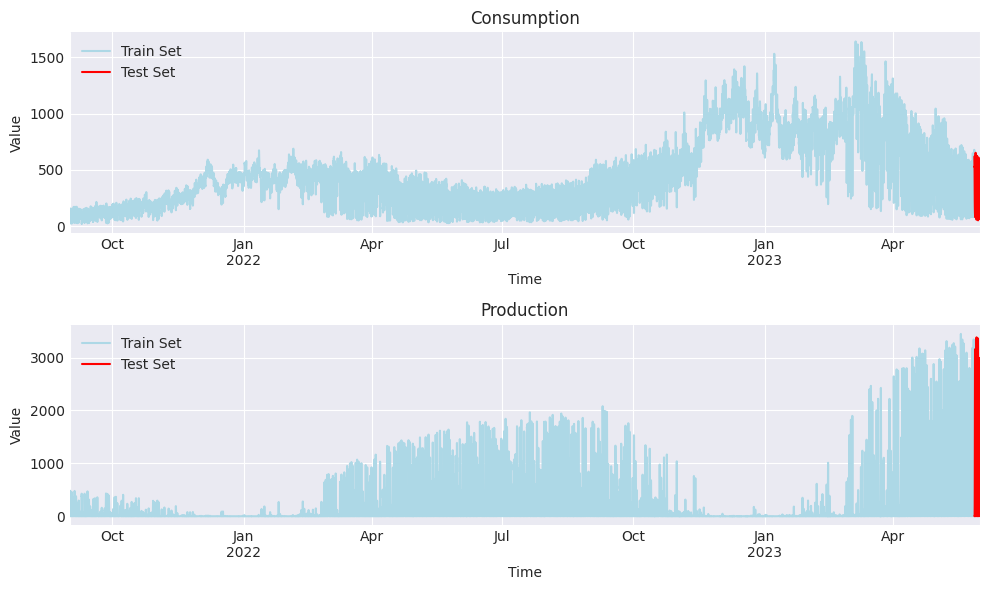

In [52]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize = (10, 6))
# Plot "consumption" on the first subplot (ax1) with different colors for train and test sets
trn_consumption.plot(ax=ax1, label="Train Set", color='lightblue')  # Plot train set in blue
tst_consumption.plot(ax=ax1, label="Test Set", color='red')  # Plot test set in red

ax1.set_title("Consumption")
ax1.set_xlabel("Time")
ax1.set_ylabel("Value")
ax1.legend()  # Show legend to distinguish train and test sets

# Plot "production" on the second subplot (ax2) with different colors for train and test sets
trn_production.plot(ax=ax2, label="Train Set", color='lightblue')  # Plot train set in blue
tst_production.plot(ax=ax2, label="Test Set", color='red')  # Plot test set in red

ax2.set_title("Production")
ax2.set_xlabel("Time")
ax2.set_ylabel("Value")
ax2.legend()  

plt.tight_layout()  
plt.show()

### 2) ARIMA, SARIMA 
- Stationary check
    - acf, pacf
    - adfuller test
- ARIMA
- SARIMA
- Auto ARIMA

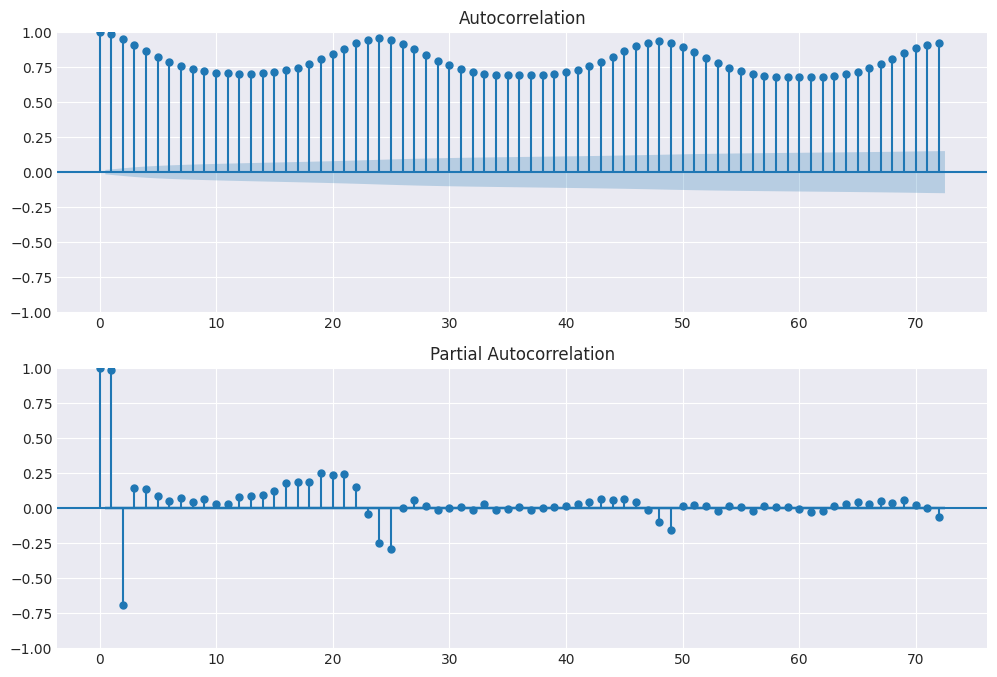

In [53]:
# Consumption ACF, PACF
fig, (ax1, ax2) = plt.subplots(2,1,  figsize=(12, 8)) 
plot_acf(seg0_data["consumption"].values.squeeze(), lags=72, ax=ax1)  
plot_pacf(seg0_data["consumption"].values.squeeze(), lags=72, ax=ax2) 
plt.show;

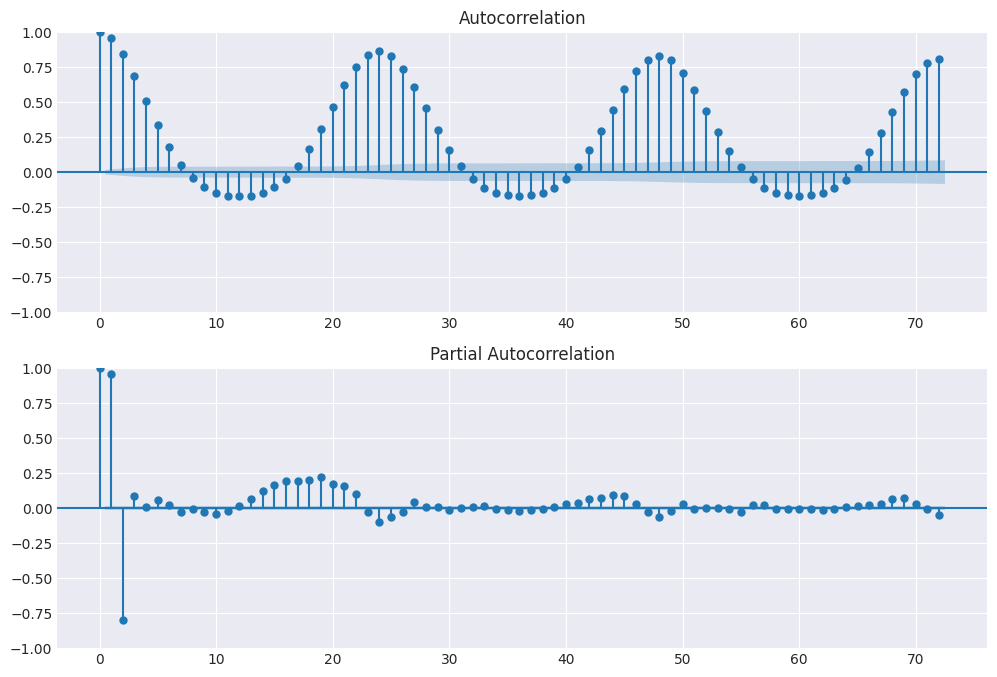

In [54]:
# Production ACF, PACF
fig, (ax1, ax2) = plt.subplots(2,1,  figsize=(12, 8)) 
plot_acf(seg0_data["production"].values.squeeze(), lags=72, ax=ax1)  
plot_pacf(seg0_data["production"].values.squeeze(), lags=72, ax=ax2) 
plt.show;

In [55]:
result = adfuller(seg0_data["consumption"])

# 결과 출력
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

ADF Statistic: -2.4730433428990453
p-value: 0.12217168188541472
Critical Values: {'1%': -3.430778373052422, '5%': -2.861729322601768, '10%': -2.566870771808984}


In [56]:
# 1st differencing 
seg0_data_diff = seg0_data["consumption"].diff().dropna()

result_after_diff = adfuller(seg0_data_diff)

# Print results after differencing
print('\nADF Statistic (After Diff):', result_after_diff[0])
print('p-value (After Diff):', result_after_diff[1])
print('Critical Values (After Diff):', result_after_diff[4])


ADF Statistic (After Diff): -28.59951815776309
p-value (After Diff): 0.0
Critical Values (After Diff): {'1%': -3.4307784011158993, '5%': -2.8617293350037323, '10%': -2.5668707784104026}


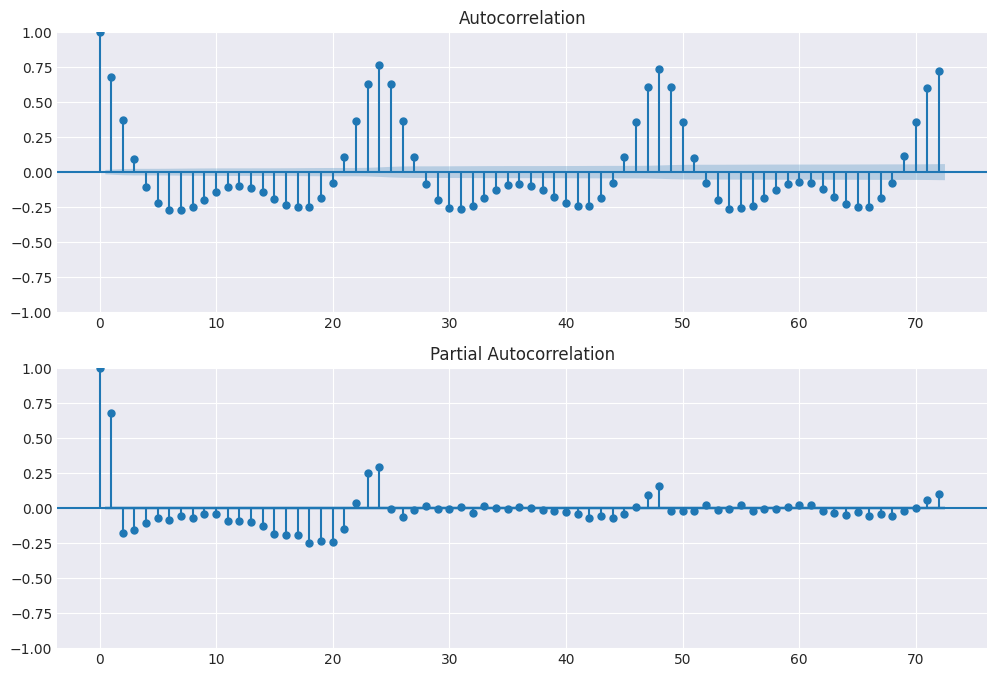

In [57]:
# Production ACF, PACF
fig, (ax1, ax2) = plt.subplots(2,1,  figsize=(12, 8)) 
plot_acf(seg0_data_diff.values.squeeze(), lags=72, ax=ax1)  
plot_pacf(seg0_data_diff.values.squeeze(), lags=72, ax=ax2) 
plt.show;

In [58]:
result = adfuller(seg0_data["production"])

# 결과 출력
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

ADF Statistic: -4.318312235721285
p-value: 0.00041287167657164445
Critical Values: {'1%': -3.430778373052422, '5%': -2.861729322601768, '10%': -2.566870771808984}


In [59]:
print(tst_consumption.index[0])
print(tst_consumption.index[-1])

2023-05-28 00:00:00
2023-05-31 23:00:00


In [60]:
# Metrics
def mape(y_pred, y_true): # mape = mean absolute percentage error
    return (np.abs(y_pred - y_true)/y_true).mean() * 100

def mae(y_pred, y_true):
    return np.abs(y_pred - y_true).mean()

def r2_score(y_pred, y_true):
    mean_y_true = np.mean(y_true)
    ss_total = np.sum((y_true - mean_y_true)**2) # SST
    ss_residual = np.sum((y_true - y_pred)**2) # SSR
    r2 = 1 - (ss_residual / ss_total)
    return r2

#### ARIMA - consumption

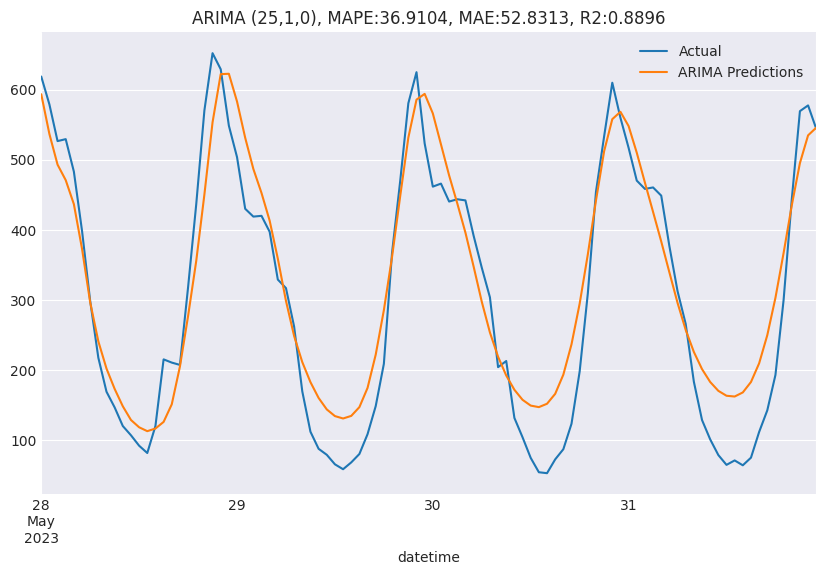

In [61]:
### ARIMA (25,1,0) ###

from statsmodels.tsa.arima.model import ARIMA
trn_consumption.index.freq = "H"

arima_cons = ARIMA(trn_consumption, order = (25,1,0)).fit()
pred = arima_cons.predict(start = tst_consumption.index[0], 
                          end = tst_consumption.index[-1], dynamic=True)
# Plot predictions
plt.figure(figsize=(10, 6))
tst_consumption.plot(label='Actual')
pred.plot(label='ARIMA Predictions')
plt.title(f"ARIMA (25,1,0), MAPE:{mape(pred.values,tst_consumption.values):.4f}, MAE:{mae(pred.values,tst_consumption.values):.4f}, R2:{r2_score(pred.values,tst_consumption.values):.4f}")
plt.legend()
plt.show()

/home/estsoft/miniconda3/envs/MathAI/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/estsoft/miniconda3/envs/MathAI/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/estsoft/miniconda3/envs/MathAI/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


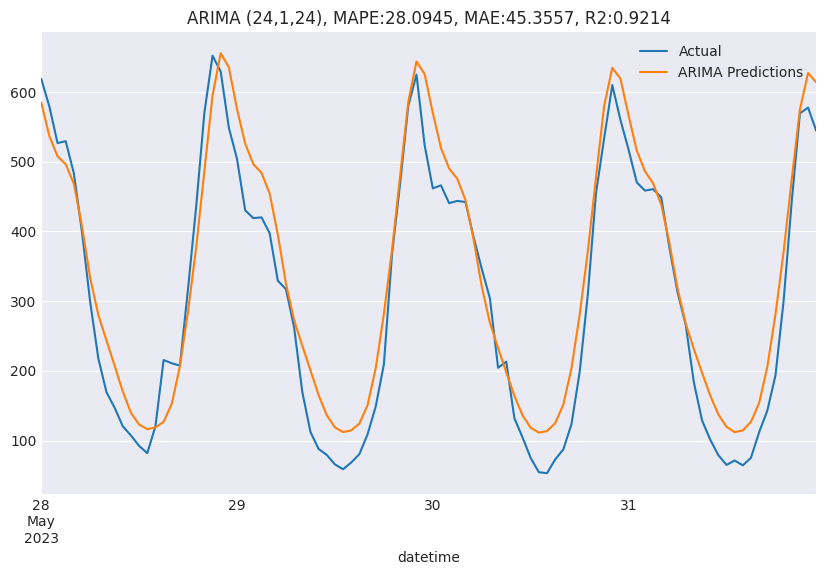

In [62]:
### ARIMA (24,1,0) ###

arima_cons = ARIMA(trn_consumption, order = (24,1,24)).fit()
pred = arima_cons.predict(start = tst_consumption.index[0], 
                          end = tst_consumption.index[-1], dynamic=True)
# Plot predictions
plt.figure(figsize=(10, 6))
tst_consumption.plot(label='Actual')
pred.plot(label='ARIMA Predictions')
plt.title(f"ARIMA (24,1,24), MAPE:{mape(pred.values,tst_consumption.values):.4f}, MAE:{mae(pred.values,tst_consumption.values):.4f}, R2:{r2_score(pred.values,tst_consumption.values):.4f}")
plt.legend()
plt.show()

#### ARIMA - production

/home/estsoft/miniconda3/envs/MathAI/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/estsoft/miniconda3/envs/MathAI/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/estsoft/miniconda3/envs/MathAI/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


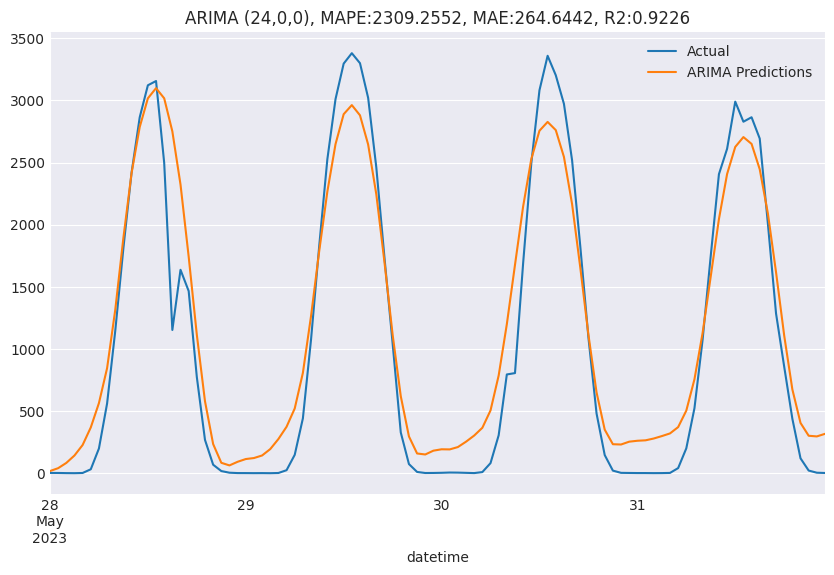

In [63]:
### ARIMA - production (24,0,0)
trn_production.index.freq = "H"

arima_prod = ARIMA(trn_production, order = (24,0,24)).fit()
pred = arima_prod.predict(start = tst_production.index[0], 
                          end = tst_production.index[-1], dynamic=True)
# Plot predictions
plt.figure(figsize=(10, 6))
tst_production.plot(label='Actual')
pred.plot(label='ARIMA Predictions')
plt.title(f"ARIMA (24,0,24), MAPE:{mape(pred.values,tst_production.values):.4f}, MAE:{mae(pred.values,tst_production.values):.4f}, R2:{r2_score(pred.values,tst_production.values):.4f}")
plt.legend()
plt.show()

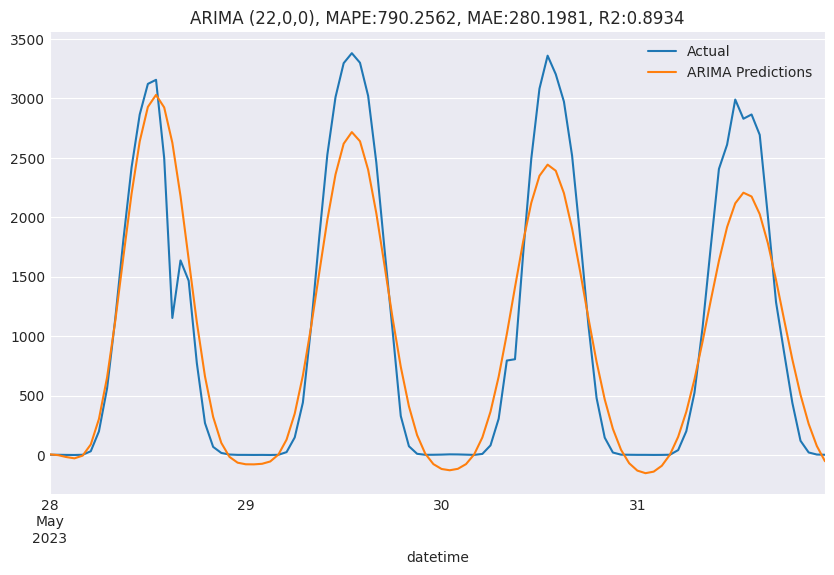

In [32]:
### ARIMA - production (22,0,0) ###
arima_prod = ARIMA(trn_production, order = (22,0,0)).fit()
pred = arima_prod.predict(start = tst_production.index[0], 
                          end = tst_production.index[-1], dynamic=True)
# Plot predictions
plt.figure(figsize=(10, 6))
tst_production.plot(label='Actual')
pred.plot(label='ARIMA Predictions')
plt.title(f"ARIMA (22,0,0), MAPE:{mape(pred.values,tst_production.values):.4f}, MAE:{mae(pred.values,tst_production.values):.4f}, R2:{r2_score(pred.values,tst_production.values):.4f}")
plt.legend()
plt.show()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           25     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.75592D+00    |proj g|=  1.94855D-04


 This problem is unconstrained.



At iterate    5    f=  5.75592D+00    |proj g|=  1.10514D-04

At iterate   10    f=  5.75592D+00    |proj g|=  7.29765D-05

At iterate   15    f=  5.75592D+00    |proj g|=  6.00937D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   25     16     20      1     0     0   1.816D-05   5.756D+00
  F =   5.7559166740361993     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


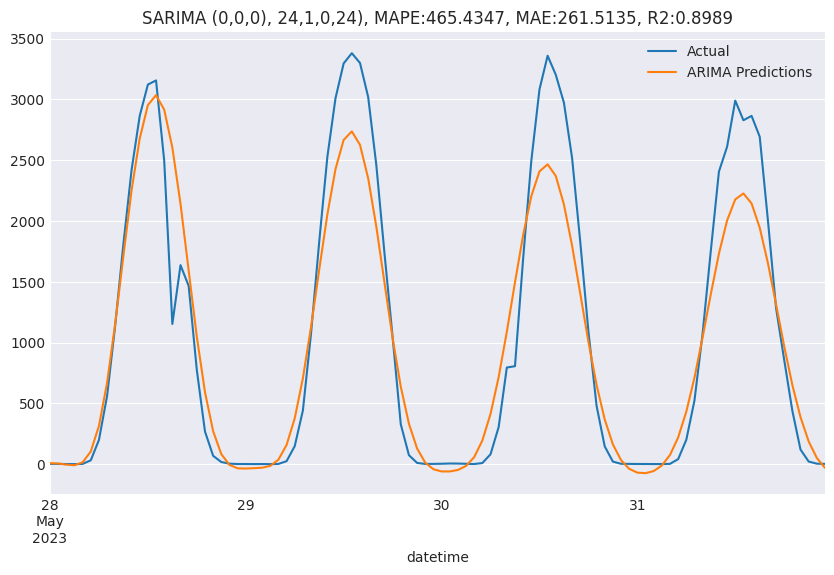

In [30]:
### SARIMA - production ###
from statsmodels.tsa.statespace.sarimax import SARIMAX
trn_production.index.freq = "H"
sarima_prod = SARIMAX(trn_production, order = (24,0,0), seasonal_order=(0,0,0,24))
pred = sarima_prod.fit().forecast(len(tst_production))

# Plot predictions
plt.figure(figsize=(10, 6))
tst_production.plot(label='Actual')
pred.plot(label='ARIMA Predictions')
plt.title(f"SARIMA (0,0,0), (24,1,0,24), MAPE:{mape(pred.values,tst_production.values):.4f}, MAE:{mae(pred.values,tst_production.values):.4f}, R2:{r2_score(pred.values,tst_production.values):.4f}")
plt.legend()
plt.show()


/home/estsoft/miniconda3/envs/MathAI/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/estsoft/miniconda3/envs/MathAI/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           49     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.23515D+01    |proj g|=  5.21714D+01


 This problem is unconstrained.



At iterate    5    f=  6.17019D+00    |proj g|=  7.57445D-01

At iterate   10    f=  5.78786D+00    |proj g|=  1.34157D-01

At iterate   15    f=  5.76751D+00    |proj g|=  3.36460D-02

At iterate   20    f=  5.75629D+00    |proj g|=  4.89861D-02

At iterate   25    f=  5.74992D+00    |proj g|=  1.52829D-02

At iterate   30    f=  5.74797D+00    |proj g|=  1.02845D-02

At iterate   35    f=  5.74631D+00    |proj g|=  9.54385D-03

At iterate   40    f=  5.74569D+00    |proj g|=  3.30774D-02

At iterate   45    f=  5.74506D+00    |proj g|=  1.97293D-02

At iterate   50    f=  5.74463D+00    |proj g|=  3.01491D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/estsoft/miniconda3/envs/MathAI/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


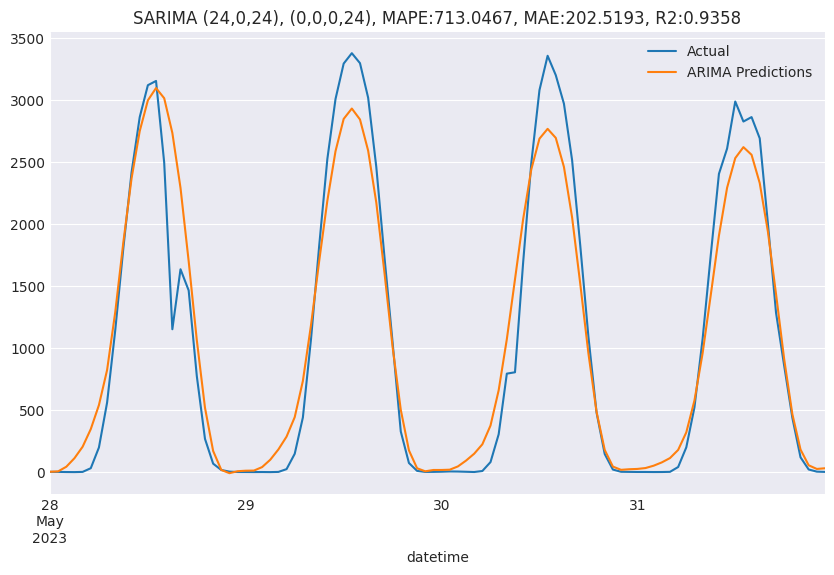

In [31]:
### SARIMA - production ###
sarima_prod = SARIMAX(trn_production, order = (24,0,24), seasonal_order=(0,0,0,24))
pred = sarima_prod.fit().forecast(len(tst_production))

# Plot predictions
plt.figure(figsize=(10, 6))
tst_production.plot(label='Actual')
pred.plot(label='ARIMA Predictions')
plt.title(f"SARIMA (24,0,24), (0,0,0,24), MAPE:{mape(pred.values,tst_production.values):.4f}, MAE:{mae(pred.values,tst_production.values):.4f}, R2:{r2_score(pred.values,tst_production.values):.4f}")
plt.legend()
plt.show()


In [ ]:
### Auto arima ### 
from pmdarima import auto_arima

# auto_arima_cons = auto_arima(trn_consumption, start_p =0, d=1, start_q=0, max_p=168, max_q=168)

: 

-> The Kernel crashed while executing code in the the current cell

시계열이 많다보니 auto arima로 진행했을 때 돌아가다가 커널이 중간에 죽어버림. 